In [24]:
import pandas as pd
import glob
import os
import json
import numpy as np
from  cycler import cycler
import fastplot
from collections import Counter, defaultdict
from statistics import mode
import statsmodels.stats.proportion
import re

country_list = ['USA', 'UK', 'HongKong',"France", "Australia", "Brazil", "Singapore"]
country_list_hongkong = ['USA', 'UK', 'Hong Kong',"France", "Australia", "Brazil", "Singapore"]
COUNTRY_TRAD={"HongKong":"HK", "UK":"UK", "USA": "US","France":"Fr", "Australia":"Aus", "Brazil":"Br", "Singapore":"Sin"}

CYCLER_LINESPOINTS=(cycler('color', ['r', 'b', 'g', 'purple', 'c']) +
                    cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]) +
                    cycler('marker', ['o', 's', 'v', 'd', '^' ]))

CYCLER_LINES=(cycler('color', ['r', 'b', 'g', 'purple', 'c']) +
                    cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]))

PLOT_ARGS = {"style":"latex", "grid":True, "figsize":(4.25,2.5), "rcParams":{'text.latex.preamble': '\\usepackage{libertine}\n\\usepackage{setspace}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}
PLOT_ARGS_LARGE = {"style":"latex", "grid":True, "figsize":(9,2.75), "rcParams":{'text.latex.preamble': '\\usepackage{libertine}\n\\usepackage{setspace}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

BEFORE_STR = "\\emph{Before-Accept}"
AFTER_STR = "\\emph{After-Accept}"
ADDITIONAL_STR = "\\emph{Additional-Visits}"

TRANSLATE_CATEGORIES = {"Computers Electronics and Technology": "Computers and Technology",
                        "Business and Consumer Services": "Business and Services",
                        "Heavy Industry and Engineering": "Industry and Engineering"}

%matplotlib inline

In [3]:
trackers = set( open("trackers-list.txt", "r").read().splitlines() )

similarweb_websites=defaultdict(set)
for c in country_list:
    similarweb_websites[c] = set(open("similarweb/{}.txt".format(c), "r" ).read().splitlines()) 
    

In [10]:
print(similarweb_websites.keys())

dict_keys(['USA', 'UK', 'HongKong', 'France', 'Australia', 'Brazil', 'Singapore'])


In [4]:
bad_domains=set("co.uk co.jp com.hk co.hu co.il com.au co.ve .co.in com.ec com.pk co.th co.nz com.br com.sg com.sa \
com.do co.za com.mx com.ly com.ua com.eg com.pe com.tr co.kr com.ng com.pe com.pk co.th \
com.au com.ph com.my com.tw com.ec com.kw co.in co.id com.com com.vn com.bd com.ar \
com.co com.vn org.uk net.gr".split())

def getGood2LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]    
    names = fqdn.split(".")
    if ".".join(names[-2:]) in bad_domains:
        return get3LD(fqdn)
    tln_array = names[-2:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

def get3LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]
    names = fqdn.split(".")
    tln_array = names[-3:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

In [7]:
df = pd.read_csv(f"../data/all_output.csv")
original_len = df.shape[0]

In [8]:
# Initialize a list to store indices of rows to be deleted
rows_to_delete = []

for index, row in df.iterrows():
    # Check if the specified columns are empty for the row
    if row['cookie_first'] == "[]" and row['cookie_click'] == "[]" and row['cookie_internal'] == "[]":
        rows_to_delete.append(index)

# Drop the identified rows
df.drop(rows_to_delete, inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Number of rows deleted: {len(rows_to_delete)}")
print(f"Percentage: {len(rows_to_delete)/original_len}")

Number of rows deleted: 1818
Percentage: 0.12011099365750529


In [9]:
df["sld"] = df["url"].apply(lambda u: getGood2LD(u.split("/")[2] ).strip() ) 
df["tld"] = df["url"].apply(lambda u: get3LD(u.split("/")[2] ).strip()  ) 

In [11]:
# adding country to the dataframe
for country in similarweb_websites:
    df[country] = (df.sld.isin(similarweb_websites[country])) | (df.tld.isin(similarweb_websites[country]))


In [12]:
print(similarweb_websites.keys())

dict_keys(['USA', 'UK', 'HongKong', 'France', 'Australia', 'Brazil', 'Singapore'])


In [13]:
similarweb_csv = pd.read_csv("similarweb/together.csv")

In [14]:
# adding categories to the dataframe
similarweb_csv["category"] = similarweb_csv["category"].apply(lambda s: TRANSLATE_CATEGORIES[s] if s in TRANSLATE_CATEGORIES else s)
categories = defaultdict(set)

for row in similarweb_csv.itertuples():
    if row.category != "ALL" and row.country in country_list_hongkong :
        categories[row.category].add(row.website)
        
for category in categories:
    df[category] = (df.sld.isin(categories[category])) | (df.tld.isin(categories[category]))


In [16]:
print(df.iloc[0])

url                                                              http://lilabeauty.com.au
landing_page                                                   https://lilabeauty.com.au/
has_found_banner                                                                    False
cookie_first                            [{"domain": "lilabeauty.com.au", "expires": 17...
cookie_click                            [{"domain": "lilabeauty.com.au", "expires": 17...
cookie_internal                         [{"domain": "lilabeauty.com.au", "expires": 17...
domains_first                           ["static.socialshopwave.com", "js.squarecdn.co...
domains_click                           ["connect.facebook.net", "static.socialshopwav...
sld                                                                     lilabeauty.com.au
tld                                                                     lilabeauty.com.au
USA                                                                                 False
UK        

In [17]:
# getting the trackers for before, after and internal banner.
# Note that only checking the tracker that is in the tracker list and not expried
def get_trackers(s):
    d = json.loads(s)
    this_trackers = set()
    for c in d:
        if (c["domain"] in trackers or getGood2LD(c["domain"]) in trackers or get3LD(c["domain"]) in trackers) and c["expires"] > 0:
            this_trackers.add(getGood2LD(c["domain"]))
    return list(this_trackers)

df["trackers_first"] = df["cookie_first"].apply(get_trackers)
df["trackers_click"] = df["cookie_click"].apply(get_trackers)
df["trackers_internal"] = df["cookie_internal"].apply(get_trackers)

In [18]:
print(df.iloc[0]["cookie_internal"])

[{"domain": "lilabeauty.com.au", "expires": 1741612638.221372, "size": 19, "name": "secure_customer_sig"}, {"domain": "lilabeauty.com.au", "expires": 1741612638.221426, "size": 14, "name": "localization"}, {"domain": "lilabeauty.com.au", "expires": 1711286238.221459, "size": 16, "name": "cart_currency"}, {"domain": ".lilabeauty.com.au", "expires": 1710163038.221479, "size": 167, "name": "_cmp_a"}, {"domain": ".lilabeauty.com.au", "expires": 1741612539.382417, "size": 204, "name": "_tracking_consent"}, {"domain": ".lilabeauty.com.au", "expires": 1741612638.221502, "size": 46, "name": "_shopify_y"}, {"domain": ".lilabeauty.com.au", "expires": 1711286139.382467, "size": 14, "name": "_orig_referrer"}, {"domain": ".lilabeauty.com.au", "expires": 1711286139.382481, "size": 16, "name": "_landing_page"}, {"domain": ".lilabeauty.com.au", "expires": 1710078437, "size": 13, "name": "_shopify_sa_p"}, {"domain": ".zipmoney.com.au", "expires": 1710078339.870312, "size": 156, "name": "__cf_bm"}, {"do

In [19]:
# group the websites by second level domain: total of 13159 websites.
def website_stats(this_df):
    num = len(this_df.index)
    trackers_first = set()
    trackers_click = set()
    trackers_internal = set()
    
    trackers_first_all = set(this_df.iloc[0].trackers_first)
    trackers_click_all = set(this_df.iloc[0].trackers_click)
    trackers_internal_all = set(this_df.iloc[0].trackers_internal)
    trackers_details = []

    has_found_banner = False
    
    tp_first = set()
    tp_click = set()
    
    countries = { c:False for c in similarweb_websites.keys()}
    cats = { c:False for c in categories.keys()}
    #+ list(similarweb_websites.keys()) + list(categories.keys())
    
    
    for i, row in this_df.iterrows():

        trackers_first |= set(row.trackers_first)
        trackers_click |= set(row.trackers_click)
        trackers_internal |= set(row.trackers_internal)
        
        trackers_first_all &= set(row.trackers_first)
        trackers_click_all &= set(row.trackers_click)
        trackers_internal_all &= set(row.trackers_internal)
        
        trackers_details.append(set(row.trackers_click))
        
        tp_first |= set([ getGood2LD(d) for d in json.loads(row.domains_first) if d != ""] )
        tp_click |= set([ getGood2LD(d) for d in json.loads(row.domains_click) if d != ""])      
        
        for c in list(similarweb_websites.keys()):
            countries[c] |= row[c]

        for c in list(categories.keys()):
            cats[c] |= row[c]
            
        if row.has_found_banner:
            has_found_banner=True
        
    trackers_only_click = trackers_click - trackers_first
    
    trackers_acc = set()
    trackers_incremental = []
    for s in trackers_details:
        trackers_acc |= s
        trackers_incremental.append(len(trackers_acc))
    
    return pd.Series({"count": num,
                      "trackers_first": trackers_first,
                      "trackers_click": trackers_click,
                      "trackers_only_click": trackers_only_click,
                      "trackers_internal": trackers_internal,
                      
                      "trackers_first_all": trackers_first_all,
                      "trackers_click_all": trackers_click_all,
                      "trackers_internal_all": trackers_internal_all,
                      
                      "trackers_incremental_nb": trackers_incremental,
                    
                      "tp_first": tp_first,
                      "tp_click": tp_click,
                      "has_found_banner": has_found_banner,
                      **countries, **cats
                     })
# grouped = df.groupby(["sld"]).apply(website_stats).reset_index()
grouped = df.groupby(["sld"]).apply(website_stats,include_groups=False).reset_index()
grouped

,sld,count,trackers_first,trackers_click,trackers_only_click,trackers_internal,trackers_first_all,trackers_click_all,trackers_internal_all,trackers_incremental_nb,...,Jobs_and_Career,Law_and_Government,News_and_Media,Pets_and_Animals,Reference_Materials,Science_and_Education,Sports,Travel_and_Tourism,Vehicles,Lifestyle
0,0123movie.net,1,{},{},{},{},{},{},{},[0],...,False,False,False,False,False,False,False,False,False,False
1,01net.com,1,{},"{yahoo.com, simpli.fi, adform.net, crwdcntrl.n...","{yahoo.com, simpli.fi, adform.net, crwdcntrl.n...","{yahoo.com, simpli.fi, adform.net, crwdcntrl.n...",{},"{yahoo.com, simpli.fi, adform.net, crwdcntrl.n...","{yahoo.com, simpli.fi, adform.net, crwdcntrl.n...",[45],...,False,False,False,False,False,False,False,False,False,False
2,0x3.com,1,{},{},{},{},{},{},{},[0],...,False,False,False,False,False,False,False,False,False,False
3,1001jeux.fr,1,{},{},{},{},{},{},{},[0],...,False,False,False,False,False,False,False,False,False,False
4,1001pneus.fr,1,{bing.com},"{doubleclick.net, bing.com}",{doubleclick.net},"{doubleclick.net, bing.com}",{bing.com},"{doubleclick.net, bing.com}","{doubleclick.net, bing.com}",[2],...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9362,zuldigital.com.br,1,{doubleclick.net},{doubleclick.net},{},{doubleclick.net},{doubleclick.net},{doubleclick.net},{doubleclick.net},[1],...,False,False,False,False,True,False,False,False,False,False
9363,zulily.com,1,{},{},{},{},{},{},{},[0],...,False,False,False,False,False,False,False,False,False,False
9364,zungfu.com,1,{},{},{},{},{},{},{},[0],...,False,False,False,False,False,False,False,False,True,False
9365,zupimages.net,2,"{yahoo.com, simpli.fi, amazon-adsystem.com, cr...","{semasio.net, simpli.fi, eyeota.net, crwdcntrl...","{semasio.net, eyeota.net, gumgum.com, socdm.co...","{semasio.net, simpli.fi, eyeota.net, crwdcntrl...",{},"{yahoo.com, simpli.fi, gumgum.com, crwdcntrl.n...","{yahoo.com, simpli.fi, gumgum.com, crwdcntrl.n...","[55, 66]",...,False,False,False,False,False,False,False,False,False,False


In [20]:
print([ele for ele in grouped[grouped['sld'] == 'zoro.com']])

['sld', 'count', 'trackers_first', 'trackers_click', 'trackers_only_click', 'trackers_internal', 'trackers_first_all', 'trackers_click_all', 'trackers_internal_all', 'trackers_incremental_nb', 'tp_first', 'tp_click', 'has_found_banner', 'USA', 'UK', 'HongKong', 'France', 'Australia', 'Brazil', 'Singapore', 'Adult', 'Arts_and_Entertainment', 'Business_and_Consumer_Services', 'Community_and_Society', 'Computers_Electronics_and_Technology', 'E-commerce_and_Shopping', 'Finance', 'Food_and_Drink', 'Gambling', 'Games', 'Health', 'Heavy_Industry_and_Engineering', 'Hobbies_and_Leisure', 'Home_and_Garden', 'Jobs_and_Career', 'Law_and_Government', 'News_and_Media', 'Pets_and_Animals', 'Reference_Materials', 'Science_and_Education', 'Sports', 'Travel_and_Tourism', 'Vehicles', 'Lifestyle']


<Figure size 640x480 with 0 Axes>

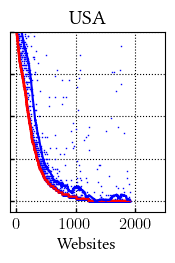

<Figure size 640x480 with 0 Axes>

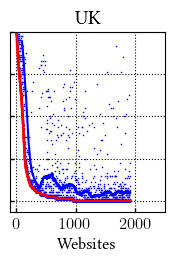

<Figure size 640x480 with 0 Axes>

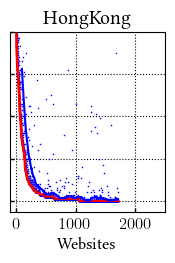

<Figure size 640x480 with 0 Axes>

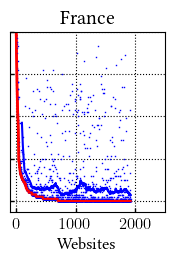

<Figure size 640x480 with 0 Axes>

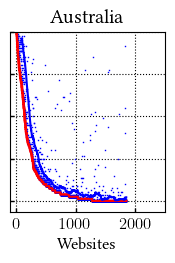

<Figure size 640x480 with 0 Axes>

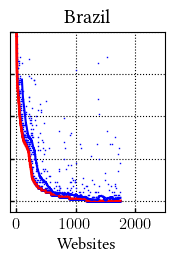

<Figure size 640x480 with 0 Axes>

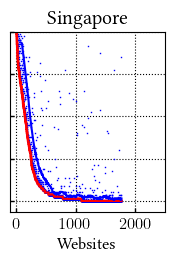

In [29]:
PLOT_ARGS_SMALL = {"style":"latex", "grid":True, "figsize":(2,2.25), "rcParams":{'text.latex.preamble': r'\usepackage{libertine}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

W=100
for c in country_list:

    plot_data = grouped [ grouped[[c]].any(axis=1) ].copy()
    missing = 0#10542 - len(plot_data.index)
    plot_data["trackers_first_nb"] = plot_data["trackers_first"].apply(len)
    plot_data["trackers_click_nb"] = plot_data["trackers_click"].apply(len)
    plot_data = plot_data[["trackers_first_nb", "trackers_click_nb"]]

    # plot_data = plot_data.append( [{"trackers_first_nb":0, "trackers_click_nb":0}]*missing ).sample(frac=1)
    plot_data = plot_data._append( [{"trackers_first_nb":0, "trackers_click_nb":0}]*missing ).sample(frac=1)

    plot_data= plot_data.sort_values(by="trackers_first_nb", ascending=False).reset_index()
    plot_list = [(BEFORE_STR,   (np.arange(len(plot_data["trackers_first_nb"].values ) ) +1 ,   plot_data["trackers_first_nb"].values  ) ),
                 (AFTER_STR, (np.arange(len(plot_data["trackers_click_nb"].values) ) +1 , plot_data["trackers_click_nb"].values ) ),
                ]

    avg = (np.arange(len(plot_data["trackers_click_nb"].values) ) +1 , plot_data["trackers_click_nb"].rolling(W).mean().values )
        
    CYCLER_LINESANDPOINTS=(cycler('color', ['r', 'b', 'b', 'b', 'c']) +
                        cycler('linestyle', ['-', '', '-.', '-', (0, (3, 1, 1, 1)) ]) +
                        cycler('marker', ['', 's', '', '', '^' ]))

    has_legend = c == "fr"
    ylabel = 'Tracker Number' if has_legend else None
    yticks = ([0,20,40,60,80],None) if has_legend else ([0,20,40,60,80],["","","","",""])
    xlabel = "{}".format(c)
    
    plot = fastplot.plot( plot_list ,None, 
                   mode='line_multi', ylabel = ylabel,
                   legend = has_legend, legend_loc='upper right', legend_ncol=1, legend_fontsize=12, legend_alpha=0.5,
                     xlabel = "Websites", linewidth=2, fontsize=12,
                   xlim = (-100, 2500), cycler = CYCLER_LINESANDPOINTS, plot_args = {"markersize": 1},
                         xticks = ([0,1000,2000],None), yticks = yticks,
                   ylim = (-5,80), **PLOT_ARGS_SMALL)

    if has_legend:
        # plot.gca().get_legend().legendHandles[1]._legmarker.set_markersize(5)
        plot.gca().get_legend().legend_handles[1].set_markersize(5)
    plot.plot(plot_list[0][1][0], plot_list[0][1][1], "-", color="red", marker=None, markersize=0)
    plot.title(xlabel)
    
    plot.plot(avg[0], avg[1])
    
    plot.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9) 
    plot.savefig("plots/cookieaccept_overall_tracker_nb_{}.pdf".format(c), bbox_inches = "tight")
    
    plot.show()

C:\Users\zhang\AppData\Local\Temp\ipykernel_10232\380868270.py:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plot.text(2.5, 115, "Consent Banner Found and Accepted", ha="center", bbox = dict(boxstyle='square,pad=0', facecolor='white', color="white"))


<Figure size 640x480 with 0 Axes>

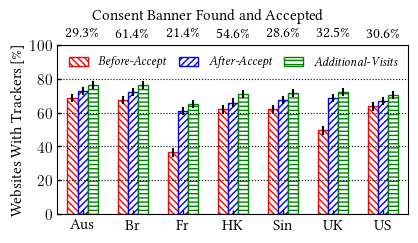

In [30]:
plot_data = []

for country in similarweb_websites.keys():
    this_grouped = grouped[grouped[country] == True]
    tot = len(this_grouped.index)
    tracker_first = len(this_grouped[this_grouped["trackers_first"].apply(lambda s: len(s) > 0 ) ].index)
    tracker_click = len(this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) > 0 ) ].index)
    tracker_internal = len(this_grouped[this_grouped["trackers_internal"].apply(lambda s: len(s) > 0 ) ].index)
    plot_data.append({"country": COUNTRY_TRAD[country],
                      BEFORE_STR: tracker_first/tot*100,
                      AFTER_STR: tracker_click/tot*100,
                      ADDITIONAL_STR: tracker_internal/tot*100,
                     })
    
plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values(by="country")
plot_df.index = plot_df["country"]
del plot_df["country"]

THIS_PLOT_ARGS = PLOT_ARGS.copy()
THIS_PLOT_ARGS["figsize"] = (4.25,2.25)
    
plot = fastplot.plot( plot_df ,None, 
               mode='bars_multi', ylabel = 'Websites With Trackers [\\%]',
               legend = True, legend_loc='upper left', legend_ncol=3, legend_fontsize="small",
               grid_axis="y",
               ylim = (0,100), **THIS_PLOT_ARGS)


for p in plot.gca().patches[:len(plot_df)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(plot_df):len(plot_df)*2]+ [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")
    
for p in plot.gca().patches[2*len(plot_df):] + [plot.gca().get_legend().get_patches()[2]]:
    p.set_hatch("----")
    p.set_edgecolor ("green")
    p.set_facecolor ("white")

#plot.gca().patches[5].set_hatch("XXXX")
#plot.gca().patches[11].set_hatch("++++")
#plot.gca().patches[17].set_hatch("....")

for i, country in enumerate(country_list):
    this_grouped = grouped[grouped[country] == True]
    n = round(len(this_grouped[this_grouped["has_found_banner"]].index)/len(this_grouped.index)*100,1)
    plot.text(i, 105, "{}\\%".format(n), ha="center", bbox = dict(boxstyle='square,pad=0', color="white"))
    
plot.text(2.5, 115, "Consent Banner Found and Accepted", ha="center", bbox = dict(boxstyle='square,pad=0', facecolor='white', color="white"))

plot.subplots_adjust(left=0.125, bottom=0.1, right=0.95, top=0.85) 

# err = plot_df.applymap(lambda v: [ e*100 for e in statsmodels.stats.proportion.proportion_confint(v*2500/100,2500,0.05) ]  )
err = plot_df.map(lambda v: [ e*100 for e in statsmodels.stats.proportion.proportion_confint(v*2500/100,2500,0.05) ]  )
for i, tup in enumerate(err.itertuples()):
    plot.gca().plot( (i-0.2,i-0.2), (tup[1]), linestyle="-", color="black"  )
    plot.gca().plot( (i,i), (tup[2]), linestyle="-", color="black" )
    plot.gca().plot( (i+0.2,i+0.2), (tup[3]), linestyle="-", color="black" )
    
plot.savefig("plots/cookieaccept_websites_with_trackers.pdf", bbox_inches = "tight")
plot.show()

<Figure size 640x480 with 0 Axes>

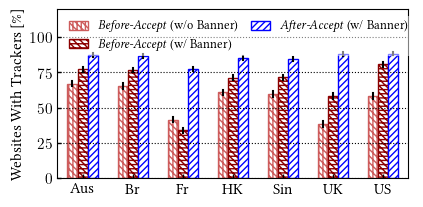

In [31]:
plot_data = []

for country in similarweb_websites.keys():
    this_grouped = grouped[grouped[country] == True]
    tot = len(this_grouped.index)
    tot_wo = len(this_grouped[this_grouped["has_found_banner"]==False].index)
    tot_w = len(this_grouped[this_grouped["has_found_banner"]==True].index)
    tracker_first_wo = len(this_grouped[ (this_grouped["trackers_first"].apply(lambda s: len(s) > 0 )) & ( this_grouped["has_found_banner"]==False) ].index)
    tracker_click_wo = len(this_grouped[ (this_grouped["trackers_click"].apply(lambda s: len(s) > 0 )) & ( this_grouped["has_found_banner"]==False) ].index)
    tracker_first_w = len(this_grouped[ (this_grouped["trackers_first"].apply(lambda s: len(s) > 0 )) & ( this_grouped["has_found_banner"]==True) ].index)
    tracker_click_w = len(this_grouped[ (this_grouped["trackers_click"].apply(lambda s: len(s) > 0 )) &( this_grouped["has_found_banner"]==True) ].index)
    plot_data.append({"country": COUNTRY_TRAD[country],
                      BEFORE_STR +  " (w/o Banner)": tracker_click_wo/tot_wo*100, # Use the "Click" visits, to take into account all 
                      BEFORE_STR + " (w/ Banner)": tracker_first_w/tot_w*100,
                      AFTER_STR +  " (w/ Banner)": tracker_click_w/tot_w*100,
                     })
    
plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values(by="country")
plot_df.index = plot_df["country"]
del plot_df["country"]

THIS_PLOT_ARGS = PLOT_ARGS.copy()
THIS_PLOT_ARGS["figsize"] = (4.25,2.25)
    
plot = fastplot.plot( plot_df ,None, 
               mode='bars_multi', ylabel = 'Websites With Trackers [\\%]',
               legend = True, legend_loc='upper left', legend_ncol=2, legend_fontsize="small", legend_alpha = 0.5,
               grid_axis="y",
               ylim = (0,120), **THIS_PLOT_ARGS)


for p in plot.gca().patches[:len(plot_df)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch(r'|\|\|\|\\')
    p.set_edgecolor ("indianred")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(plot_df):2*len(plot_df)] + [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch(r'-\-\-\-\\')
    p.set_edgecolor ("darkred")
    p.set_facecolor ("white")

for p in plot.gca().patches[2*len(plot_df):] + [plot.gca().get_legend().get_patches()[2]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")

plot.subplots_adjust(left=0.125, bottom=0.1, right=0.95, top=0.85) 

# err = plot_df.applymap(lambda v: [ e*100 for e in statsmodels.stats.proportion.proportion_confint(v*2500/100,2500,0.05) ]  )
err = plot_df.map(lambda v: [ e*100 for e in statsmodels.stats.proportion.proportion_confint(v*2500/100,2500,0.05) ]  )
for i, tup in enumerate(err.itertuples()):
    plot.gca().plot( (i-0.2,i-0.2), (tup[1]), linestyle="-", color="black"  )
    plot.gca().plot( (i,i), (tup[2]), linestyle="-", color="black" )
    plot.gca().plot( (i+0.2,i+0.2), (tup[3]), linestyle="-", color="black" )

plot.savefig("plots/cookieaccept_websites_with_trackers_separate.pdf", bbox_inches = "tight")
plot.show()

<Figure size 640x480 with 0 Axes>

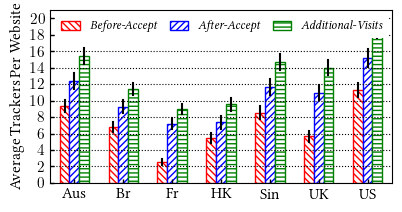

In [34]:
plot_data = []
plot_data_error = []
for country in similarweb_websites.keys():
    this_grouped = grouped[grouped[country] == True]
    tracker_first = this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 ) ]["trackers_first"].apply(len).mean()
    tracker_click = this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 ) ]["trackers_click"].apply(len).mean()
    tracker_internal = this_grouped[this_grouped["trackers_internal"].apply(lambda s: len(s) >= 0 ) ]["trackers_internal"].apply(len).mean()
    
    plot_data.append({"country": COUNTRY_TRAD[country],
                      BEFORE_STR: tracker_first,
                      AFTER_STR: tracker_click,
                      ADDITIONAL_STR: tracker_internal,
                     })
    
    tracker_first = this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 ) ]["trackers_first"].apply(len)
    tracker_click = this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 ) ]["trackers_click"].apply(len)
    tracker_internal = this_grouped[this_grouped["trackers_internal"].apply(lambda s: len(s) >= 0 ) ]["trackers_internal"].apply(len)
      
    plot_data_error.append({"country": COUNTRY_TRAD[country],
                      BEFORE_STR: (round(np.mean(tracker_first) - 1.95*np.std(tracker_first)/np.sqrt(len(tracker_first)),2),
                                   round(np.mean(tracker_first) + 1.95*np.std(tracker_first)/np.sqrt(len(tracker_first)),2)),
                      AFTER_STR: (round(np.mean(tracker_click) - 1.95*np.std(tracker_click)/np.sqrt(len(tracker_click)),2),
                                   round(np.mean(tracker_click) + 1.95*np.std(tracker_click)/np.sqrt(len(tracker_click)),2)),
                      ADDITIONAL_STR: (round(np.mean(tracker_internal) - 1.95*np.std(tracker_click)/np.sqrt(len(tracker_internal)),2),
                                   round(np.mean(tracker_internal) + 1.95*np.std(tracker_click)/np.sqrt(len(tracker_internal)),2)),
                     })
    
plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values(by="country")
plot_df.index = plot_df["country"]
del plot_df["country"]

THIS_PLOT_ARGS = PLOT_ARGS.copy()
THIS_PLOT_ARGS["figsize"] = (4.25,2.25)


plot = fastplot.plot( plot_df [[BEFORE_STR, AFTER_STR, ADDITIONAL_STR] ]  ,None, 
               mode='bars_multi', ylabel = 'Average Trackers Per Website',
               legend = True, legend_loc='upper left', legend_ncol=3, legend_fontsize=9,
               grid_axis="y", yticks=(np.arange(0,21,2) ,None),
               ylim = (0,21), **THIS_PLOT_ARGS)

for p in plot.gca().patches[:len(plot_df)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(plot_df):2*len(plot_df)] + [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")

for p in plot.gca().patches[2*len(plot_df):] + [plot.gca().get_legend().get_patches()[2]]:
    p.set_hatch("----")
    p.set_edgecolor ("green")
    p.set_facecolor ("white")
    
#plot.gca().patches[5].set_hatch("XXXX")
#plot.gca().patches[11].set_hatch("++++")
#plot.gca().patches[17].set_hatch("....")

for i, tup in enumerate(plot_df.itertuples()):
    #print(i, tup.Index)
    this_d = None
    for d in plot_data_error:
        if d["country"] == tup.Index:
            this_d = d
    #print (tup.Index, this_d)
    plot.gca().plot( (i-0.2,i-0.2), (this_d[BEFORE_STR]), linestyle="-", color="black"  )
    plot.gca().plot( (i,i), (this_d[AFTER_STR]), linestyle="-", color="black" )
    plot.gca().plot( (i+0.2,i+0.2), (this_d[ADDITIONAL_STR]), linestyle="-", color="black" )
    
plot.savefig("plots/cookieaccept_trackers_per_website.pdf")
plot.show()

<Figure size 640x480 with 0 Axes>

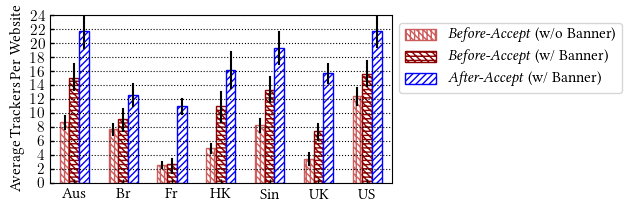

In [36]:
plot_data = []
plot_data_error = []

for country in similarweb_websites.keys():
    this_grouped = grouped[grouped[country] == True]
    tracker_first_wo = this_grouped[(this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 )) & ( this_grouped["has_found_banner"]==False)]["trackers_first"].apply(len).mean()
    tracker_click_wo = this_grouped[(this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 )) & ( this_grouped["has_found_banner"]==False)]["trackers_click"].apply(len).mean()
    tracker_first_w = this_grouped[(this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 )) & ( this_grouped["has_found_banner"]==True)]["trackers_first"].apply(len).mean()
    tracker_click_w = this_grouped[(this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 )) & ( this_grouped["has_found_banner"]==True)]["trackers_click"].apply(len).mean()
     
    plot_data.append({"country": COUNTRY_TRAD[country],
                      BEFORE_STR +  " (w/o Banner)": tracker_click_wo, # Use the "Click" visits, to take into account all 
                      BEFORE_STR + " (w/ Banner)": tracker_first_w,
                      AFTER_STR +  " (w/ Banner)": tracker_click_w,
                     })

    tracker_first_wo = this_grouped[(this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 )) & ( this_grouped["has_found_banner"]==False)]["trackers_first"].apply(len)
    tracker_click_wo = this_grouped[(this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 )) & ( this_grouped["has_found_banner"]==False)]["trackers_click"].apply(len)
    tracker_first_w = this_grouped[(this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 )) & ( this_grouped["has_found_banner"]==True)]["trackers_first"].apply(len)
    tracker_click_w = this_grouped[(this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 )) & ( this_grouped["has_found_banner"]==True)]["trackers_click"].apply(len)
     
    plot_data_error.append({"country": COUNTRY_TRAD[country],
                      BEFORE_STR +  " (w/o Banner)": (round(np.mean(tracker_click_wo) - 1.95*np.std(tracker_click_wo)/np.sqrt(len(tracker_click_wo)),2),
                                   round(np.mean(tracker_click_wo) + 1.95*np.std(tracker_click_wo)/np.sqrt(len(tracker_click_wo)),2)),
                      BEFORE_STR + " (w/ Banner)": (round(np.mean(tracker_first_w) - 1.95*np.std(tracker_click)/np.sqrt(len(tracker_first_w)),2),
                                   round(np.mean(tracker_first_w) + 1.95*np.std(tracker_first_w)/np.sqrt(len(tracker_first_w)),2)),
                      AFTER_STR +  " (w/ Banner)": (round(np.mean(tracker_click_w) - 1.95*np.std(tracker_click_w)/np.sqrt(len(tracker_click_w)),2),
                                   round(np.mean(tracker_click_w) + 1.95*np.std(tracker_click_w)/np.sqrt(len(tracker_click_w)),2)),
                     })
    
plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values(by="country")
plot_df.index = plot_df["country"]
del plot_df["country"]

THIS_PLOT_ARGS = PLOT_ARGS.copy()
THIS_PLOT_ARGS["figsize"] = (4.25,2.25)

plot = fastplot.plot(plot_df[[BEFORE_STR + " (w/o Banner)", BEFORE_STR + " (w/ Banner)", AFTER_STR + " (w/ Banner)"]],
                     None, 
                     mode='bars_multi', 
                     ylabel='Average Trackers Per Website',
                     legend=True, 
                     legend_loc='upper left', 
                     legend_ncol=2, 
                     legend_fontsize=8.75, 
                     legend_alpha=1,
                     grid_axis="y", 
                     yticks=(np.arange(0, 25, 2), None),
                     ylim=(0, 21), 
                     **THIS_PLOT_ARGS)

# Modify here to adjust the legend position
plot.gca().legend(loc='upper left', bbox_to_anchor=(1, 1))

for p in plot.gca().patches[:len(plot_df)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch(r'|\|\|\|\\')
    p.set_edgecolor ("indianred")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(plot_df):2*len(plot_df)] + [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch(r'-\-\-\-\\')
    p.set_edgecolor ("darkred")
    p.set_facecolor ("white")

for p in plot.gca().patches[2*len(plot_df):] + [plot.gca().get_legend().get_patches()[2]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")
    

for i, tup in enumerate(plot_df.itertuples()):
    #print(i, tup.Index)
    this_d = None
    for d in plot_data_error:
        if d["country"] == tup.Index:
            this_d = d
    #print (tup.Index, this_d)
    plot.gca().plot( (i-0.2,i-0.2), (this_d[BEFORE_STR +  " (w/o Banner)"]), linestyle="-", color="black"  )
    plot.gca().plot( (i,i), (this_d[BEFORE_STR +  " (w/ Banner)"]), linestyle="-", color="black" )
    plot.gca().plot( (i+0.2,i+0.2), (this_d[AFTER_STR +  " (w/ Banner)"]), linestyle="-", color="black" )
    
# plot.savefig("../plots/cookieaccept_trackers_per_website_separate.pdf")
plot.savefig("plots/cookieaccept_trackers_per_website_separate.pdf")
plot.show()


<Figure size 640x480 with 0 Axes>

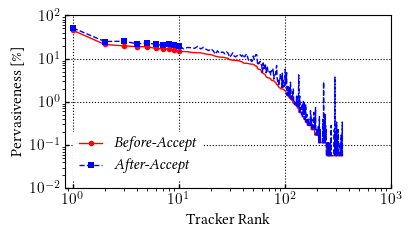

Trackers on >= 1% of websites: 117 -> 131


In [37]:
tracker_first = Counter()
tracker_click = Counter()
tot = len(this_grouped.index)

for row in this_grouped.itertuples():
    for t in row.trackers_first:
        tracker_first[t] +=1
    for t in row.trackers_click:
        tracker_click[t] +=1        

plot_data = []
for t in tracker_first:
    plot_data.append({
        "tracker": t,
        BEFORE_STR: tracker_first[t]/tot*100,
        AFTER_STR: tracker_click[t]/tot*100,
    })
    
plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values(by = BEFORE_STR, ascending=False)


plot_list = [(BEFORE_STR,   (np.arange(len(plot_df[BEFORE_STR].values ) ) +1 ,   plot_df[BEFORE_STR].values  ) ),
             (AFTER_STR, (np.arange(len(plot_df[AFTER_STR].values) ) +1 , plot_df[AFTER_STR].values ) ),
            ]

plot = fastplot.plot( plot_list ,None, 
               mode='line_multi', ylabel = 'Pervasiveness [\\%]',
               legend = True, legend_loc='lower left', legend_ncol=1,
               yscale = "log", xscale = "log", xlabel = "Tracker Rank",
               xlim = (0.85, None), cycler = CYCLER_LINESPOINTS, plot_args = {"markersize": 4, "markevery": slice(0, 10, 1)},
               ylim = (0.01,100), **PLOT_ARGS)

plot.savefig("plots/cookieaccept_tracker_pervasiveness_log.pdf")
plot.show()

print("Trackers on >= 1% of websites: {} -> {}".format( len([e for e in plot_list[0][1][1] if e > 1 ]), len([e for e in plot_list[1][1][1] if e >1 ]) ))

C:\Users\zhang\AppData\Local\Temp\ipykernel_10232\1810028308.py:51: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plot.text(11, 122, "Consent Banner Found and Accepted", ha="center", bbox = dict(boxstyle='square,pad=0', facecolor='white', color="white"))


<Figure size 640x480 with 0 Axes>

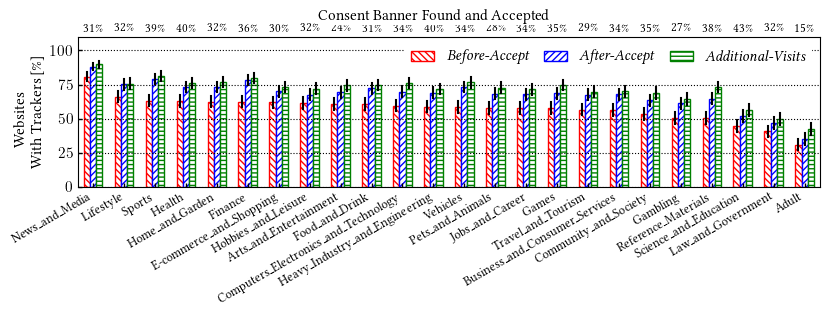

In [38]:
plot_data = []

for category in categories.keys():
    this_grouped = grouped[grouped[category] == True]
    this_grouped = this_grouped [ this_grouped[country_list].any(axis=1) ] 
    tot = len(this_grouped.index)
    tracker_first = len(this_grouped[this_grouped["trackers_first"].apply(lambda s: len(s) > 0 ) ].index)
    tracker_click = len(this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) > 0 ) ].index)
    tracker_internal = len(this_grouped[this_grouped["trackers_internal"].apply(lambda s: len(s) > 0 ) ].index)
    if tot>0:
        plot_data.append({"category": category,
                          BEFORE_STR: tracker_first/tot*100,
                          AFTER_STR: tracker_click/tot*100,
                          ADDITIONAL_STR: tracker_internal/tot*100,
                         })
    else:
        print ("    Empty")
    
plot_df = pd.DataFrame(plot_data)
plot_df.index = plot_df["category"]

plot_df = plot_df.sort_values(by = BEFORE_STR, ascending=False)
del plot_df["category"]
THIS_PLOT_ARGS_LARGE = {"style":"latex", "grid":True, "figsize":(9,2), "rcParams":{'text.latex.preamble': '\\usepackage{libertine}\n\\usepackage{setspace}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

plot = fastplot.plot( plot_df[[BEFORE_STR, AFTER_STR, ADDITIONAL_STR] ] ,None, 
               mode='bars_multi', ylabel = 'Websites\\\\With Trackers [\\%]', xticks_rotate = 30, xticks_fontsize = "small",
               legend = True, legend_loc='upper right', legend_ncol=3, legend_alpha=1.0,
               grid_axis="y", yticks = ([0,25,50,75,100], None),
               ylim = (0,110), **THIS_PLOT_ARGS_LARGE)

for p in plot.gca().patches[:len(plot_df)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(plot_df):2*len(plot_df)]+ [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")
    
for p in plot.gca().patches[2*len(plot_df):] + [plot.gca().get_legend().get_patches()[2]]:
    p.set_hatch("----")
    p.set_edgecolor ("green")
    p.set_facecolor ("white")

for i, category in enumerate(plot_df.index.values):
    this_grouped = grouped[grouped[category] == True]
    n = int(len(this_grouped[this_grouped["has_found_banner"]].index)/len(this_grouped.index)*100)
    plot.text(i, 114, "\\small {}\\%".format(n), ha="center", bbox = dict(boxstyle='square,pad=0', color="white"))
    
plot.text(11, 122, "Consent Banner Found and Accepted", ha="center", bbox = dict(boxstyle='square,pad=0', facecolor='white', color="white"))

plot.subplots_adjust(left=0.125, bottom=0.1, right=0.95, top=0.85) 


# err = plot_df.applymap(lambda v: [ e*100 for e in statsmodels.stats.proportion.proportion_confint(v*500/100,500,0.05) ]  )
err = plot_df.map(lambda v: [ e*100 for e in statsmodels.stats.proportion.proportion_confint(v*500/100,500,0.05) ]  )
for i, tup in enumerate(err.itertuples()):
    plot.gca().plot( (i-0.2,i-0.2), (tup[1]), linestyle="-", color="black"  )
    plot.gca().plot( (i,i), (tup[2]), linestyle="-", color="black" )
    plot.gca().plot( (i+0.2,i+0.2), (tup[3]), linestyle="-", color="black" )
    
plot.savefig("plots/cookieaccept_websites_with_trackers_category.pdf", bbox_inches = "tight")
plot.show()


<Figure size 640x480 with 0 Axes>

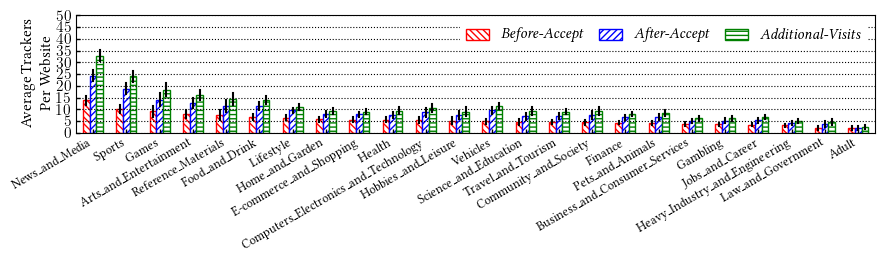

In [41]:
plot_data = []
plot_data_error = []

for category in categories.keys():
    this_grouped = grouped[grouped[category] == True]
    this_grouped = this_grouped [ this_grouped[country_list].any(axis=1) ] 
    tracker_first = this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 ) ]["trackers_first"].apply(len).mean()
    tracker_click = this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 ) ]["trackers_click"].apply(len).mean()
    tracker_internal = this_grouped[this_grouped["trackers_internal"].apply(lambda s: len(s) >= 0 ) ]["trackers_internal"].apply(len).mean()
    
    plot_data.append({"category": category,
                     BEFORE_STR: tracker_first,
                      AFTER_STR: tracker_click,
                      ADDITIONAL_STR: tracker_internal,
                     })
    
    tracker_first = this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 ) ]["trackers_first"].apply(len)
    tracker_click = this_grouped[this_grouped["trackers_click"].apply(lambda s: len(s) >= 0 ) ]["trackers_click"].apply(len)
    tracker_internal = this_grouped[this_grouped["trackers_internal"].apply(lambda s: len(s) >= 0 ) ]["trackers_internal"].apply(len)
      
    plot_data_error.append({"category": category,
                      BEFORE_STR: (round(np.mean(tracker_first) - 1.95*np.std(tracker_first)/np.sqrt(len(tracker_first)),2),
                                   round(np.mean(tracker_first) + 1.95*np.std(tracker_first)/np.sqrt(len(tracker_first)),2)),
                      AFTER_STR: (round(np.mean(tracker_click) - 1.95*np.std(tracker_click)/np.sqrt(len(tracker_click)),2),
                                   round(np.mean(tracker_click) + 1.95*np.std(tracker_click)/np.sqrt(len(tracker_click)),2)),
                      ADDITIONAL_STR: (round(np.mean(tracker_internal) - 1.95*np.std(tracker_click)/np.sqrt(len(tracker_internal)),2),
                                   round(np.mean(tracker_internal) + 1.95*np.std(tracker_click)/np.sqrt(len(tracker_internal)),2)),
                     })
    
plot_df = pd.DataFrame(plot_data)
plot_df.index = plot_df["category"]
plot_df = plot_df.sort_values(by = BEFORE_STR, ascending=False)

del plot_df["category"]
plot = fastplot.plot( plot_df[[BEFORE_STR, AFTER_STR, ADDITIONAL_STR] ] ,None, 
               mode='bars_multi', ylabel = '\\begin{center}Average Trackers\\\\Per Website\\end{center}', xticks_rotate = 30,  xticks_fontsize = "small",
               legend = True, legend_loc='upper right', legend_ncol=3,
               grid_axis="y",yticks = (np.arange(0,55,5), None),
               ylim = (0,50), **PLOT_ARGS_LARGE)

for p in plot.gca().patches[:len(plot_df)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(plot_df):2*len(plot_df)] + [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")

for p in plot.gca().patches[2*len(plot_df):] + [plot.gca().get_legend().get_patches()[2]]:
    p.set_hatch("----")
    p.set_edgecolor ("green")
    p.set_facecolor ("white")
    

for i, tup in enumerate(plot_df.itertuples()):
    for d in plot_data_error:
        if d["category"] == tup.Index:
            this_d = d
    plot.gca().plot( (i-0.2,i-0.2), (this_d[BEFORE_STR]), linestyle="-", color="black"  )
    plot.gca().plot( (i,i), (this_d[AFTER_STR]), linestyle="-", color="black" )
    plot.gca().plot( (i+0.2,i+0.2), (this_d[ADDITIONAL_STR]), linestyle="-", color="black" )
plot.savefig("plots/cookieaccept_trackers_per_website_category.pdf")
plot.show()
plot_df["Increase"] = plot_df[AFTER_STR] - plot_df[BEFORE_STR]

